In [10]:
!git clone https://github.com/IntelLabs/bayesian-torch
!pip install bayesian-torch/.

fatal: destination path 'bayesian-torch' already exists and is not an empty directory.
Processing ./bayesian-torch
  Preparing metadata (setup.py) ... done
  Created wheel for bayesian-torch: filename=bayesian_torch-0.4.0-py3-none-any.whl size=77122 sha256=7e4a4fcd3277af1df2531750f4da55a1c07bc001795c32baead857dec2539552
  Stored in directory: /root/.cache/pip/wheels/c4/64/36/327a5aa82508f440c69defc36b554b49f41c2b5780c95fb461
Successfully built bayesian-torch
  Attempting uninstall: bayesian-torch
    Found existing installation: bayesian-torch 0.4.0
    Uninstalling bayesian-torch-0.4.0:
      Successfully uninstalled bayesian-torch-0.4.0


In [11]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms.autoaugment import AutoAugmentPolicy
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss



import PIL
import math
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

torch.manual_seed(38)


In [12]:
# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Hyper-parameters

num_epochs = 100
batch_size = 50
learning_rate = 0.001


In [13]:
simple_trafos = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
])

aug_trafos = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),
    torchvision.transforms.ToTensor(),
])


# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True,
                                           transform=simple_trafos,
                                           download=True)

train_aug_dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True,
                                           transform=aug_trafos,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data/',
                                          train=False,
                                          transform=simple_trafos)

test_aug_dataset = torchvision.datasets.MNIST(root='./data/',
                                          train=False,
                                          transform=aug_trafos)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

train_aug_loader = torch.utils.data.DataLoader(dataset=train_aug_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

test_aug_loader = torch.utils.data.DataLoader(dataset=test_aug_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

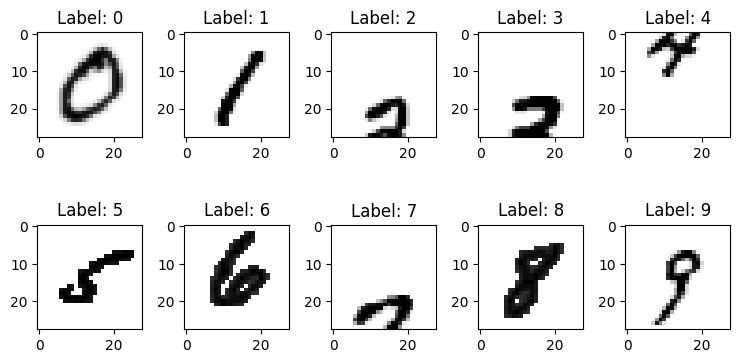

In [14]:
def plot_set_images(n_row, n_col, images, labels, label_text="Label: "):
  num=len(images)
  num_row=n_row
  num_col=n_col
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i in range(num):
      ax = axes[i//num_col, i%num_col]
      ax.imshow(images[i][0], cmap='gray_r')
      ax.set_title('{}{}'.format(label_text, labels[i]))
  plt.tight_layout()
  plt.show()

images_set = []
labels_set = []
j=0
for i in range(10):
  while i != train_dataset[j][1]:
    j += 1
  images_set.append(train_aug_dataset[j][0])
  labels_set.append(train_aug_dataset[j][1])
plot_set_images(2, 5, images_set, labels_set, "Label: ")

In [15]:
const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": False,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 0.5,
}

# model = torchvision.models.resnet18(pretrained=True)
# dnn_to_bnn(model, const_bnn_prior_parameters)

In [16]:
def test(model, test_loader):
  total_acc_test=0
  model.eval()
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
       for i, (X, labels) in enumerate(test_loader):
          X = X.to(device)
          labels = labels.to(device)
          Z =  model(X)
          total_acc_test += (Z.max(dim=1)[1] == labels).sum().item()

  print('Acc_Test =', total_acc_test / len(test_loader.dataset),sep="\t")
  return total_acc_test / len(test_loader.dataset)


In [17]:
def train(model, train_loader, learning_rate, T1=1, T2=1):
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), learning_rate)


  for epoch in range(num_epochs):
    losses = []
    for i, (images, labels) in (enumerate(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        outputs =  model(images).to(device)
        loss1 = criterion(outputs, labels).to(device)
        kl = get_kl_loss(model).to(device)

        loss = ((loss1**(1./T1)) + ((kl / batch_size)**T2)).to(device)
        # print(loss.item())
        losses.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch%5==0:
        print("epoch : " + str(epoch))
        test(model, test_loader)
        test(model, test_aug_loader)
        print('epoch : ' + str(epoch) +' -->  loss_Train = ' + str(np.array(losses).mean()))
        print()
  return model, losses


In [ ]:
models = []
losses = []
test_acc = []
test_aug_acc = []
T1 = [0.6, 0.7, 0.8, 0.9, 1]



print("train dataset is augmented:")
for t1 in T1 :
    print("")
    print("T = " + str(t1))
    model = torchvision.models.resnet18(pretrained=False).to(device)
    model.fc = nn.Linear(model.fc.in_features, 10)
    dnn_to_bnn(model, const_bnn_prior_parameters)
    models.append(model)
    _, loss = train(model.to(device), train_aug_loader, learning_rate, T1=t1, T2=1)

    test_acc.append(test(model, test_loader))
    test_aug_acc.append(test(model, test_aug_loader))
    print("-----------------------------------------------------------------------------------")




